In [1]:
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import gym
import ray
from ray.rllib.agents import ppo, a3c, cql, ddpg, dqn

gym.logger.set_level(40)

sys.path.append("..")

from source.envs.env import WhitedBasicModel
from source.solvers.ray_solver import RaySolver
from source.estimators.estimator import SMMEstimator

%load_ext autoreload
%autoreload 1

A3C_Trainer = a3c.A3CTrainer
PPO_Trainer = ppo.PPOTrainer
DQNTrainer = dqn.DQNTrainer

lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


In [3]:
ray.shutdown()
ray.init()
env = WhitedBasicModel(env_config={"structural_params": {"gamma": [0.9,0.96],
                                                         "delta": [0.1, 0.3],
                                                         "theta": [0.5, 0.8],
                                                         "rho": [0.3, 0.8],
                                                         "sigma": [0., 0.15],
                                                        }, 
                                   "env_params": {"psi_func": lambda i, k: 0.01*i**2/(2*k)
                                                 },
                                   "is_mutable": True,
                                   
                                  })
solver = RaySolver(env=env,
                   trainer=A3C_Trainer,
                   solver_params={"verbose": True, "episodes": 10,
                                  "trainer_config": {
                                      "num_workers": 8,
                                      "gamma": env.current_structural_params.get("gamma", 0.99),
                                  }
                                  })
solver.train()
ray.shutdown()

(pid=82732) 2022-02-07 11:58:37,650	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=84584) 2022-02-07 11:58:37,595	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=14144) 2022-02-07 11:58:37,631	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=73012) 2022-02-07 11:58:37,778	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=81572) 2022-02-07 11:58:37,754	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip

agent_timesteps_total: 0
custom_metrics: {}
date: 2022-02-07_11-58-38
done: false
episode_len_mean: .nan
episode_media: {}
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: a0bc6e18c3d949c28aa1f67512eeec5b
hostname: LAPTOP-SE74DK6U
info:
  learner:
    default_policy:
      batch_count: 10
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0001
        entropy_coeff: 0.01
        grad_gnorm: 73.28607177734375
        policy_entropy: 29.957185745239258
        policy_loss: -41.618125915527344
        vf_loss: 15.902438163757324
  num_steps_sampled: 10
  num_steps_trained: 10
iterations_since_restore: 1
node_ip: 127.0.0.1
num_healthy_workers: 8
off_policy_estimator: {}
perf:
  cpu_util_percent: 61.1
  ram_util_percent: 82.5
pid: 85868
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf: {}
time_since_restore: 0.1960442066192627
time_this_iter_s: 0.19604420661926

In [5]:
sample_obs, sample_action, sample_reward = solver.sample(param_dict={"gamma": 0.9,
                                                                     "delta": 0.15,
                                                                     "theta": 0.5,
                                                                     "rho": 0.5,
                                                                     "sigma": 0.15,
                                                                     })


In [6]:
N = 1000000
T = 100

def posterior_sample_params(action=sample_action, reward=sample_reward, N=N, obs=sample_obs,):
    theta_sample = np.random.normal(loc=1.,scale=1.,size=N)
    rho_sample = np.random.normal(loc=1.,scale=1.,size=N)
    sigma_sample = np.random.normal(loc=0.5,scale=1.,size=N)
    k = obs[0,:]
    z = obs[1,:]
    I = action.reshape(-1)*k/19
    r = reward.reshape(-1)

    for t in range(T-1):
        # evaluate probability of particles
        z_t = (r[t]+I[t])/k[t]**theta_sample

        eps_reward = np.log(z[t+1])-rho_sample*np.log(z_t)
        q_reward = stats.norm.pdf(eps_reward, loc=0, scale=sigma_sample)
        q_reward = np.nan_to_num(q_reward, copy=False)
        if q_reward.sum() == 0.0:
            continue

        eps = np.log(z[t+1])-rho_sample*np.log(z[t])
        q = stats.norm.pdf(eps, loc=0, scale=sigma_sample)
        q = np.nan_to_num(q, copy=False)
        # resample particles according to probability
        resample_index_reward = np.random.choice(np.arange(N), N, p=q_reward/q_reward.sum())
        theta_sample = theta_sample[resample_index_reward]
        
        resample_index = np.random.choice(np.arange(N), N, p=q/q.sum())
        rho_sample = rho_sample[resample_index]
        sigma_sample = sigma_sample[resample_index]

    return theta_sample, rho_sample, sigma_sample


In [7]:
theta_prior = np.random.normal(loc=1.,scale=1.,size=N)
rho_prior = np.random.normal(loc=1.,scale=1.,size=N)
sigma_prior = np.random.normal(loc=0.5,scale=1.,size=N)

theta_post, rho_post, sigma_post = posterior_sample_params()

<ipython-input-6-d944525fc853>:17: RuntimeWarning: invalid value encountered in log
  eps_reward = np.log(z[t+1])-rho_sample*np.log(z_t)


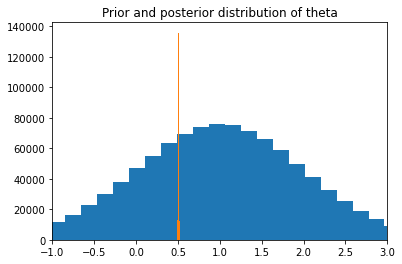

In [8]:
plt.hist(theta_prior, bins=50)
plt.hist(theta_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of theta')
plt.show()

In [9]:
theta_post.mean(), theta_post.std()

(0.5048971398431468, 0.0064468185243038625)

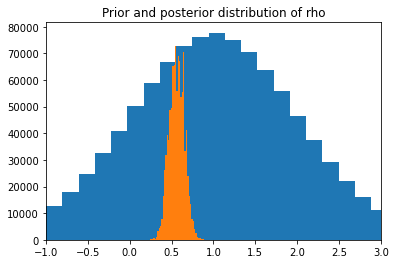

In [10]:
plt.hist(rho_prior, bins=50)
plt.hist(rho_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of rho')
plt.show()

In [11]:
rho_post.mean(), rho_post.std()

(0.5631677717196912, 0.08989937743941004)

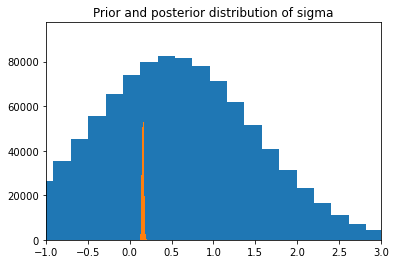

In [12]:
plt.hist(sigma_prior, bins=50)
plt.hist(sigma_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of sigma')
plt.show()

In [13]:
sigma_post.mean(), sigma_post.std()

(0.15643966725818817, 0.011491885290655611)